In [1]:
#@title Setup libraries & dependencies
import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split

from keras.utils import np_utils

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Dependencies Ready")

Dependencies Ready


In [2]:
#@markdown ### Settings for image processing:
image_metadata_size         = 20 #@param {type:"integer"}
image_use_color             = False #@param {type:"boolean"}
image_do_data_augmentation  = False

#@markdown ### NN Settings:
nn_hidden_layers_sizes  = '200 65 30' #@param {type:"string"}
nn_output_type          = 'softmax' #@param ["lineal", "softmax"]
nn_epochs               = 50#@param {type:"integer"}
nn_learning_rate        = 0.005 #@param {type:"number"}


image_dimensions  = (image_metadata_size, image_metadata_size, (3 if image_use_color else 1))
inputs_q          = image_dimensions[0] * image_dimensions[1] * image_dimensions[2]

hidden_layers = []
for layer_len in nn_hidden_layers_sizes.split(' '):
  hidden_layers.append(int(layer_len))

softmax_output_flag = (nn_output_type[:7] == 'softmax')

print("Image Dimensions are ", image_dimensions)
print("RNA MLP Backpropagation configuration is [", inputs_q, hidden_layers, ("softmax" if softmax_output_flag else "Dense[1]"))


Image Dimensions are  (20, 20, 1)
RNA MLP Backpropagation configuration is [ 400 [200, 65, 30] softmax


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

path          = '/content/gdrive/My Drive/WHEELCHAIR_DATASET'
training_path = '/TRAINING'
testing_path  = '/TESTING'

training_full_path  = path + training_path
testing_full_path   = path + testing_path

Mounted at /content/gdrive


In [7]:
#@title Load dataset images
def load_images(images_path):
  classes_ori = [] 
  images_ori  = []
  da_ori      = []

  all_dirs = os.listdir(images_path)

  for each_dir in all_dirs:
      directory_path = images_path + '/' + each_dir 
      images_in_path = os.listdir(directory_path)

      for each_image in images_in_path:
            image_is_da = (each_image[:2] == 'da')
            
            if image_do_data_augmentation or (not image_is_da): 
                image = Image.open(directory_path + "/" + each_image)
                
                if image_dimensions[2] == 1:
                  image_type = 'L'
                else:
                  image_type = 'RGB'

                image = image.convert(image_type)
                image = image.resize((image_dimensions[0], image_dimensions[1]), Image.ANTIALIAS)
                
                image_array = np.array(image)
                
                classes_ori.append(each_dir)
                images_ori.append(image_array)
                da_ori.append(image_is_da)

  return classes_ori, images_ori, da_ori, image_type

classes_train, images_train, da_flag_train, image_type_train = load_images(training_full_path)
print("# Training datatet:")
print("- Classes #", len(classes_train))
print("- Images  #", len(classes_train))

print("\n")

classes_test, images_test, da_flag_test, image_type_test = load_images(testing_full_path)
print("# Testing dataset:")
print("- Classes #", len(classes_test))
print("- Images  #", len(images_test))

print("\n")
print((len(images_test) + len(images_train)), " image(s) have been loaded loaded")

# Training datatet:
- Classes # 20
- Images  # 20


# Testing dataset:
- Classes # 21
- Images  # 21


41  image(s) have been loaded loaded


In [8]:
#@title Image & Classes Processing
def plot_image(imag):
  if image_dimensions[2] == 1:
    plt.imshow((imag*255).reshape(image_dimensions[0], image_dimensions[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(image_dimensions).astype(np.uint8))
  plt.axis("off")  

def prepare_images_list(image_list):    
  arr = np.array(image_list).astype('float32') / 255.
  arr = arr.reshape((len(arr), inputs_q))  
  return np.array(arr)

def prepare_classes_list(classesList, mapping_dict = None):
  if mapping_dict == None:
    dict_aux = list(set(classesList))
    mapping_dict = dict(zip(dict_aux, range(len(dict_aux))))
  
  y = []
  for cl in classesList:
      y.append( mapping_dict[cl] )
  
  dummy_y = np_utils.to_categorical(y)
  return np.array(y), np.array(dummy_y), mapping_dict

input_training = prepare_images_list(images_train)
input_testing  = prepare_images_list(images_test)

classes_training, classes_training_enc, mapping_dict = prepare_classes_list(classes_train)
classes_testing, classes_testing_enc, _ = prepare_classes_list(classes_test, mapping_dict)

classes_map = [x for x,y in mapping_dict.items()]

print("Images & classes have been processed")

Images & classes have been processed


In [9]:
#@title Model Computing

input_layer   = Input(shape=(inputs_q,), name='input_img')
each_layer_it = input_layer

aux_name      = 'hidd_'
aux_id        = 1 

for hidden_layer in hidden_layers:  
    auxlayerName = aux_name + str(aux_id)
    aux_id = aux_id + 1
    each_layer_it = Dense(hidden_layer, activation = "sigmoid", name = auxlayerName)(each_layer_it)

if softmax_output_flag:
    output_layer = Dense(units = len(mapping_dict), activation = 'softmax', name = 'output')(each_layer_it)
else:
    output_layer = Dense(1, activation  =None, name = 'output')(each_layer_it)

opt = keras.optimizers.Adam(learning_rate = nn_learning_rate)

model = Model(input_layer, output_layer, name = 'RNA')
if softmax_output_flag:
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
else:
    model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])

model.summary()

Model: "RNA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 400)]             0         
_________________________________________________________________
hidd_1 (Dense)               (None, 200)               80200     
_________________________________________________________________
hidd_2 (Dense)               (None, 65)                13065     
_________________________________________________________________
hidd_3 (Dense)               (None, 30)                1980      
_________________________________________________________________
output (Dense)               (None, 2)                 62        
Total params: 95,307
Trainable params: 95,307
Non-trainable params: 0
_________________________________________________________________


In [10]:
#@title Model Training

training_cases, validation_cases, y_t, y_v = train_test_split(
  input_training, 
  (classes_training_enc if softmax_output_flag else classes_training), 
  test_size = 0.1
)

print("For training stage, ")
print(len(training_cases), "/", len(input_training), " images are for training, and the remaining ")
print(len(validation_cases), "/", len(input_training), " images are for validation.")

print("\n")
print("Training in process...")

history = model.fit(
  training_cases, y_t,
  epochs = nn_epochs, 
  validation_data=(validation_cases, y_v,)
) 

print("\n")
print("Training is now complete")

For training stage, 
18 / 20  images are for training, and the remaining 
2 / 20  images are for validation.


Training in process...
Epoch 1/50
1/1 [==============================] - 13s 13s/step - loss: 0.9925 - accuracy: 0.5000 - val_loss: 0.7229 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 0.7277 - accuracy: 0.5000 - val_loss: 0.7006 - val_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 22ms/step - loss: 0.7021 - accuracy: 0.5000 - val_loss: 0.7312 - val_accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - 0s 21ms/step - loss: 0.7311 - accuracy: 0.5000 - val_loss: 0.7455 - val_accuracy: 0.5000
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.7449 - accuracy: 0.5000 - val_loss: 0.7411 - val_accuracy: 0.5000
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.7404 - accuracy: 0.5000 - val_loss: 0.7271 - val_accuracy: 0.5000
Epoch 7/50
1/1 [================

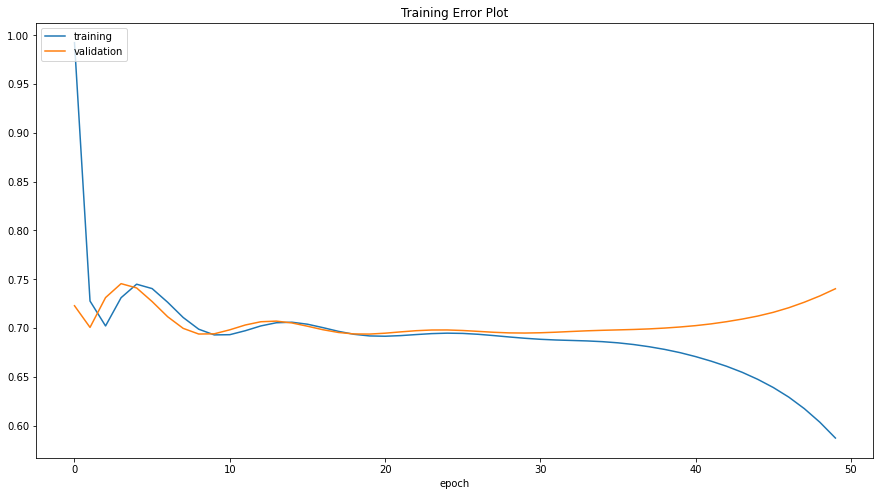

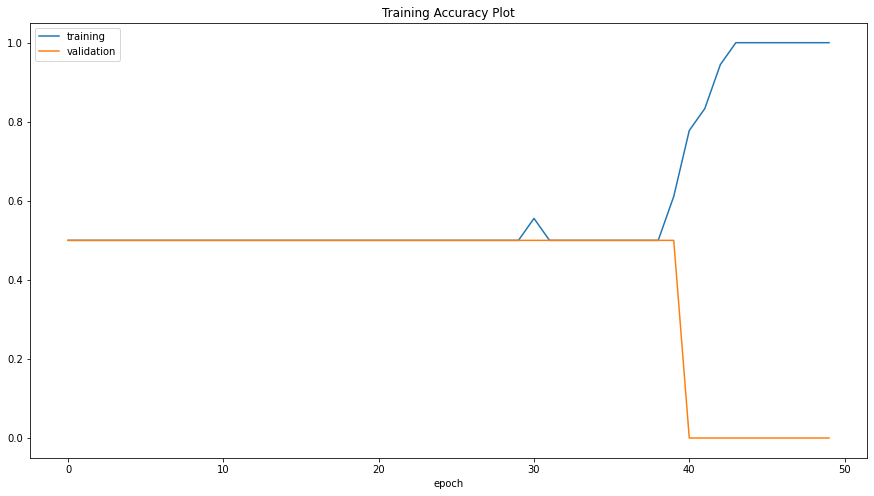

In [11]:
#@title Display training performance
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Error Plot')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

plt.figure(figsize=(15,8)) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy Plot')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

Report:
                 precision    recall  f1-score   support

  NO_WHEELCHAIR       0.90      0.90      0.90        10
WITH_WHEELCHAIR       0.90      0.90      0.90        10

       accuracy                           0.90        20
      macro avg       0.90      0.90      0.90        20
   weighted avg       0.90      0.90      0.90        20



Confusion Matrix


,p:NO_WHEELCHAIR,p:WITH_WHEELCHAIR
r:NO_WHEELCHAIR,9,1
r:WITH_WHEELCHAIR,1,9


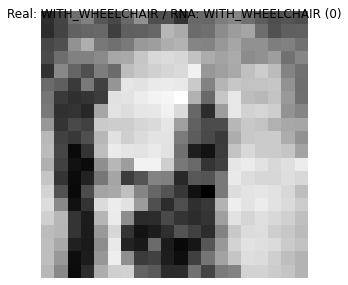

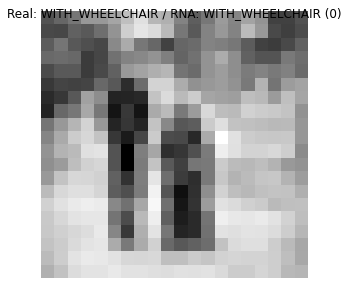

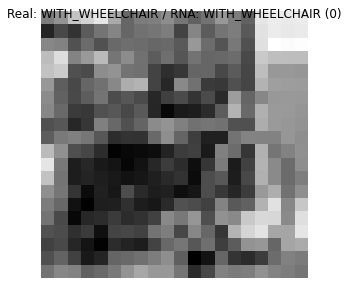

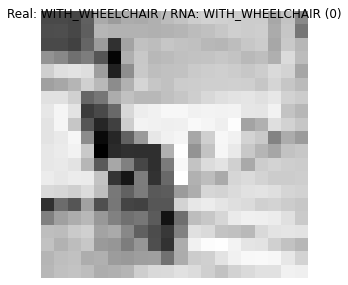

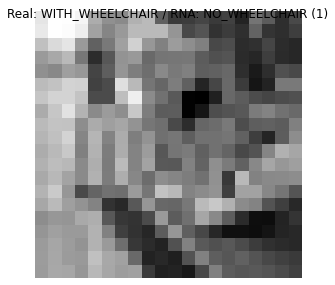

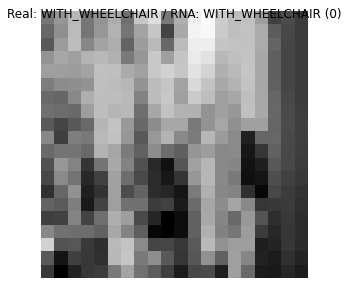

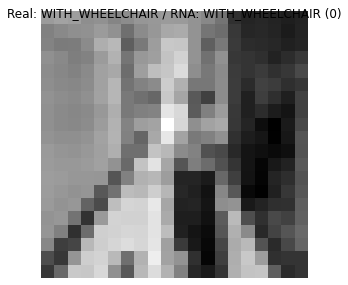

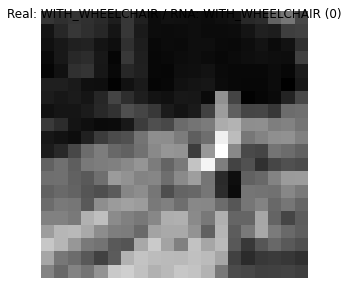

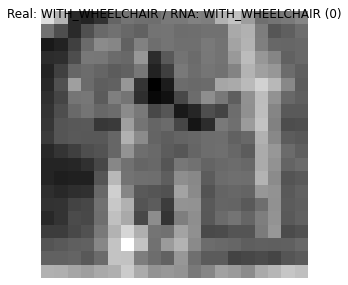

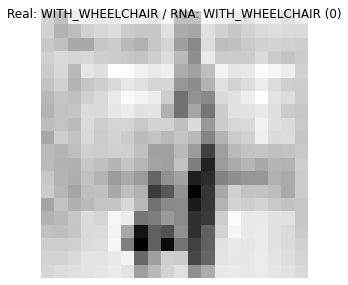

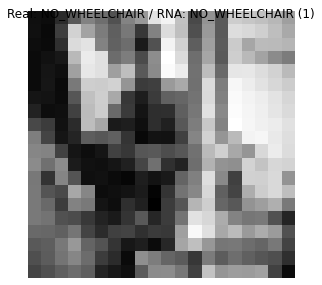

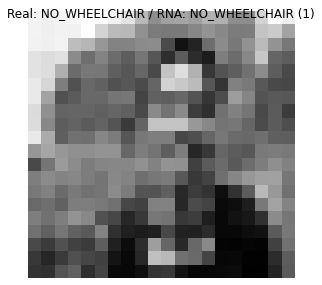

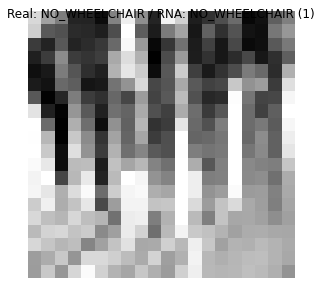

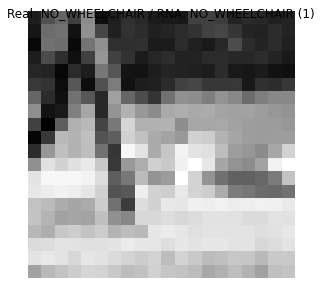

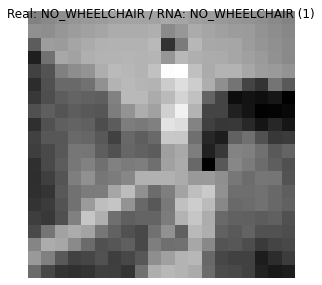

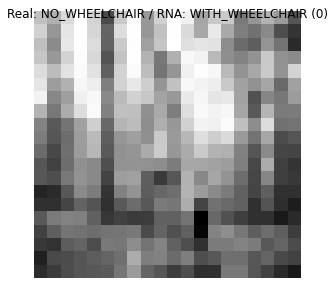

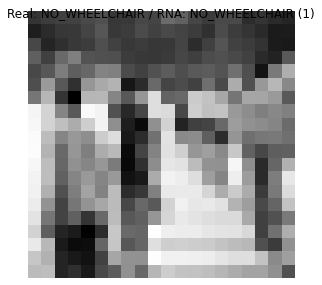

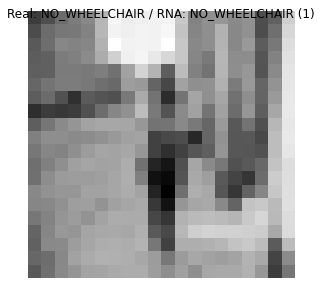

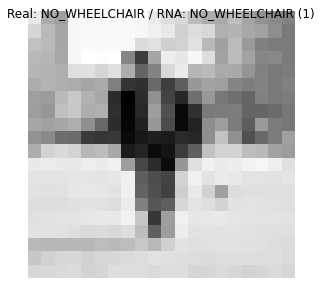

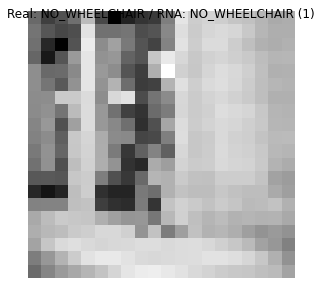

In [12]:
#@title Re-classify training data with NN

debug_image_details = True

def test_model(x, y, da_flag, classes_map, display_images = True):
    obtained_classes = model.predict(x)

    class_threshold   = 0.5
    predicted_classes = []
    real_classes      = []
    
    for i in range(len(x)):
        correct_class = classes_map[y[i]] 

        if softmax_output_flag:
            predicted_class_id        = int(np.argmax(obtained_classes[i], axis = 0))
            predicted_class_id_final  = predicted_class_id
        else:
            predicted_class_id        = obtained_classes[i][0]       
            predicted_class_id_final  = int(predicted_class_id)
            if (predicted_class_id - predicted_class_id_final) > class_threshold and (predicted_class_id_final + 1) < len(classes_map):
                 predicted_class_id_final = predicted_class_id_final + 1

        if predicted_class_id_final < 0 or predicted_class_id_final >= len(classes_map):
            predicted_class_name = "Invalid Class :: " + str(predicted_class_id_final)
        else:      
            predicted_class_name = classes_map[predicted_class_id_final]

        real_classes.append(correct_class)
        predicted_classes.append(predicted_class_name)

        plot_title = 'Real: ' + correct_class + ' / RNA: ' 
        plot_title = plot_title + predicted_class_name + ' (' + str( predicted_class_id ) +')'    

        if display_images:
            fig = plt.figure()
            fig.suptitle( plot_title )
            plot_image( x[i] )
            
            plt.tight_layout()
            fig = plt.gcf()

    print("Report:")
    print(classification_report(real_classes, predicted_classes))

    print("\n")
    print("Confusion Matrix")
    cm = confusion_matrix(real_classes, predicted_classes, labels = classes_map)
    cmtx = pd.DataFrame(
      cm, 
      index   = ['r:{:}'.format(x) for x in classes_map], 
      columns = ['p:{:}'.format(x) for x in classes_map]
    )
    cmtx = cmtx.sort_index()
    cols = list(cmtx.columns.values)
    cols.sort()
    display(cmtx[cols])
    
test_model(input_training, classes_training, da_flag_train, classes_map, debug_image_details)

1/1 [==============================] - 0s 15ms/step - loss: 0.6889 - accuracy: 0.5714


Testing Scenario Result Summary
    Error:  0.6888651251792908
    Exactitud:  0.5714285969734192


Report:
                 precision    recall  f1-score   support

  NO_WHEELCHAIR       0.60      0.55      0.57        11
WITH_WHEELCHAIR       0.55      0.60      0.57        10

       accuracy                           0.57        21
      macro avg       0.57      0.57      0.57        21
   weighted avg       0.57      0.57      0.57        21



Confusion Matrix


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


,p:NO_WHEELCHAIR,p:WITH_WHEELCHAIR
r:NO_WHEELCHAIR,6,5
r:WITH_WHEELCHAIR,4,6


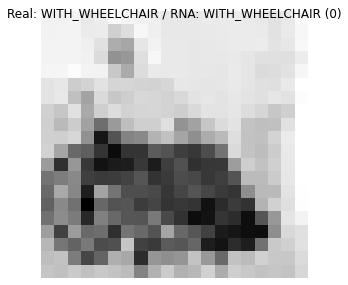

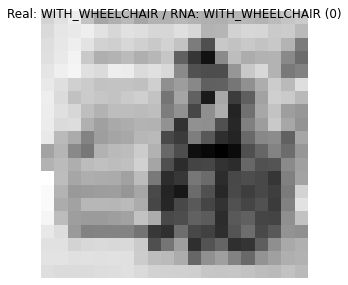

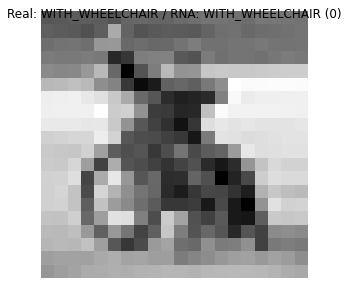

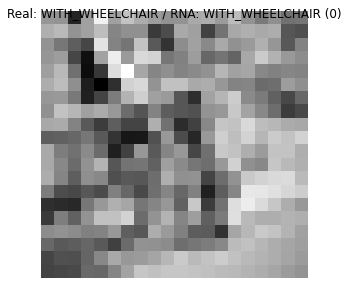

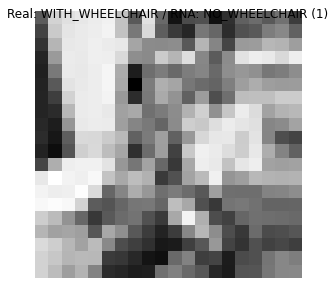

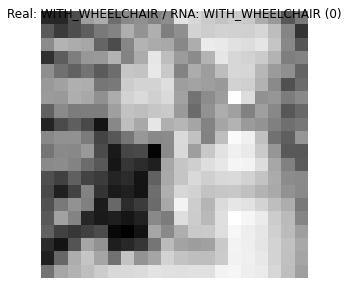

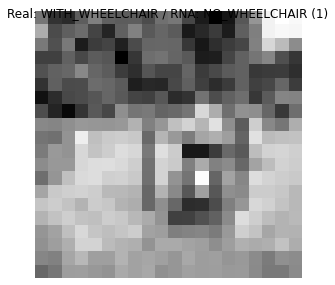

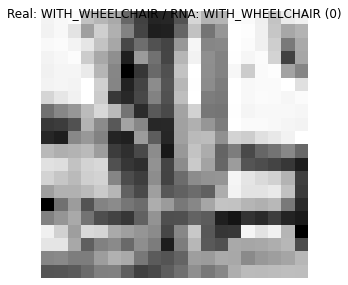

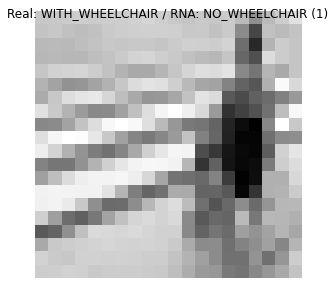

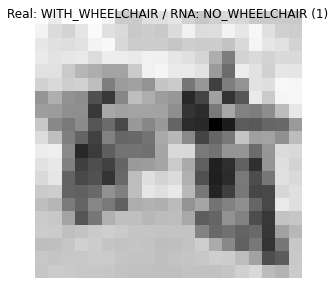

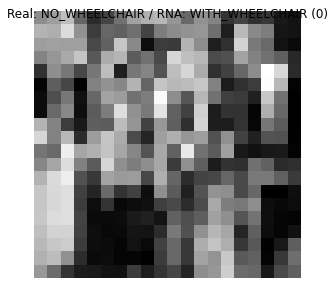

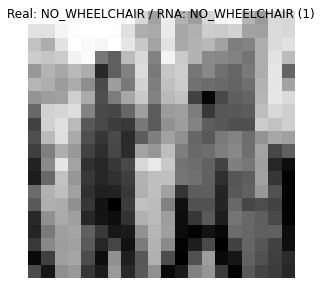

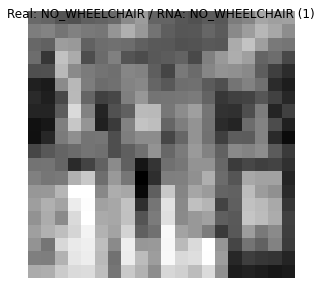

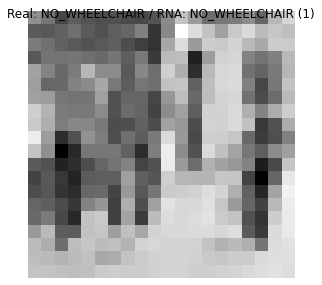

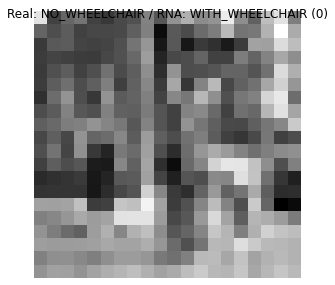

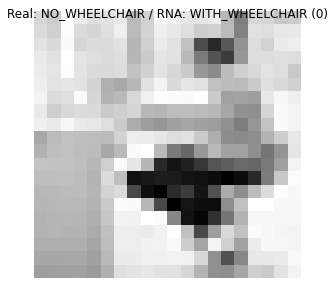

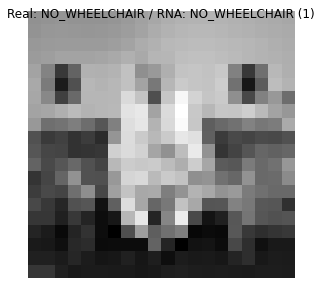

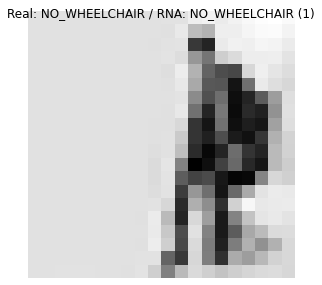

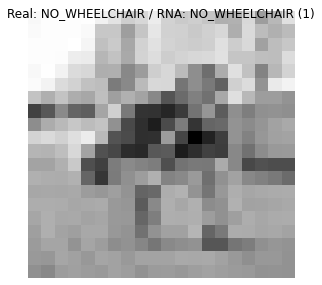

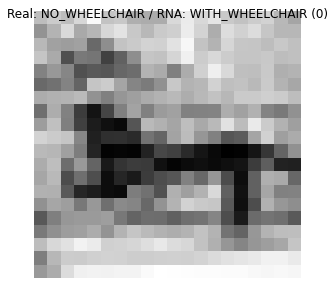

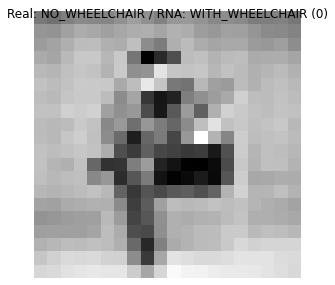

In [13]:
#@title Classify Testing Scenarios
 
debug_image_details = True

run_result = model.evaluate(input_testing, (classes_testing_enc if softmax_output_flag else classes_testing),)

print("\n")
print("Testing Scenario Result Summary")
print("    Error: ", run_result[0])
print("    Exactitud: ", run_result[1])
print("\n")

test_model(input_testing, classes_testing, da_flag_test, classes_map, debug_image_details)